**Goal:** Is to develop a machine learning approach to make predictions on the trip duration (seconds) which is a regression task.

**1. Demographic information of Customer & Vendor**
- id - a unique identifier for each trip
- vendor_id - a code assigned to each driver to establish a recordkeeping of the trip
- passenger_count - the number of passengers in the vehicle (driver enterd value)

**2. Information about the Trip**
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- pickup_longitude - longitude where the meter was engaged
- pickup_latitude - latitude where the meter was engaged
- dropoff_longitude - longitude where the meter was disengaged
- dropoff_latitude - latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward immediately; N=stored and Not forward trip)

> **trip_duration(Target)** - duration of the trip in seconds

In [1]:
import numpy as np
import pandas as pd
import pickle
import sklearn
from sklearn.metrics import mean_squared_error, r2_score # Evaluation metric
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from haversine import haversine
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (22, 6)
sns.set(style = 'white')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Exploratory Data Analysis and Data Preparation

In [2]:
data_path = r'/home/daniel/Desktop/programming/pythondatascience/datascience/datascienceprojects'

# Dataset for modelling
data = pd.read_csv(f"{data_path}/{'datasets'}/{'nyc_taxi_trip_duration.csv'}")
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  729322 non-null  object 
 1   vendor_id           729322 non-null  int64  
 2   pickup_datetime     729322 non-null  object 
 3   dropoff_datetime    729322 non-null  object 
 4   passenger_count     729322 non-null  int64  
 5   pickup_longitude    729322 non-null  float64
 6   pickup_latitude     729322 non-null  float64
 7   dropoff_longitude   729322 non-null  float64
 8   dropoff_latitude    729322 non-null  float64
 9   store_and_fwd_flag  729322 non-null  object 
 10  trip_duration       729322 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 61.2+ MB


## Check for Outliers

In [4]:
data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,7.293220e+05
mean,1.535403,1.662055,-73.973513,40.750919,-73.973422,40.751775,9.522291e+02
std,0.498745,1.312446,0.069754,0.033594,0.069588,0.036037,3.864626e+03
min,1.000000,0.000000,-121.933342,34.712234,-121.933304,32.181141,1.000000e+00
25%,1.000000,1.000000,-73.991859,40.737335,-73.991318,40.735931,3.970000e+02
50%,2.000000,1.000000,-73.981758,40.754070,-73.979759,40.754509,6.630000e+02
75%,2.000000,2.000000,-73.967361,40.768314,-73.963036,40.769741,1.075000e+03
max,2.000000,9.000000,-65.897385,51.881084,-65.897385,43.921028,1.939736e+06


In [5]:
data.skew()

vendor_id             -0.141968
passenger_count        2.135237
pickup_longitude    -444.219710
pickup_latitude       35.369490
dropoff_longitude   -449.890467
dropoff_latitude     -23.503536
trip_duration        186.678437
dtype: float64

## Converting the datetime features to the right format

In [6]:
data.pickup_datetime = pd.to_datetime(data.pickup_datetime)
data.dropoff_datetime = pd.to_datetime(data.dropoff_datetime)

# Converting Yes/No flags to 1 and 0
data.store_and_fwd_flag = data.store_and_fwd_flag.map({'Y': 1, 'N': 0})

data.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
trip_duration                  int64
dtype: object

Check for inconsistency, here we are trying to see whether the difference between the dropoff and pickup time is similar to the trip duration.

In [7]:
check_trip_duration = (data.dropoff_datetime - data.pickup_datetime).map(lambda x: x.total_seconds())
duration_difference = data[np.abs(np.array(check_trip_duration) - np.array(data['trip_duration'])) > 1]
duration_difference.shape

(0, 11)

We can see that they are exactly the same meaning there is no inconsistency in the data

## Target Exploration (Trip duration)

It is crucial to understand it in detail as this is what we are trying to predict accurately.

In [8]:
data.groupby('trip_duration')['trip_duration'].mean().sort_values(ascending=False)

trip_duration
1939736    1939736.0
86391        86391.0
86387        86387.0
86378        86378.0
86377        86377.0
             ...    
5                5.0
4                4.0
3                3.0
2                2.0
1                1.0
Name: trip_duration, Length: 6296, dtype: float64

Notice there are trip durations of 1 second which is impossible and the is a trip of 1939736.0 which is also absurd. We have to drop these outliers/entries

In [9]:
data.trip_duration.describe() / 3600 # trip duration in hours

count    202.589444
mean       0.264508
std        1.073507
min        0.000278
25%        0.110278
50%        0.184167
75%        0.298611
max      538.815556
Name: trip_duration, dtype: float64

It can be seen that the trip duration is highly skewed and might create problems at the prediction stage. One idea is to log transform the trip duration before prediction to visualize it better.

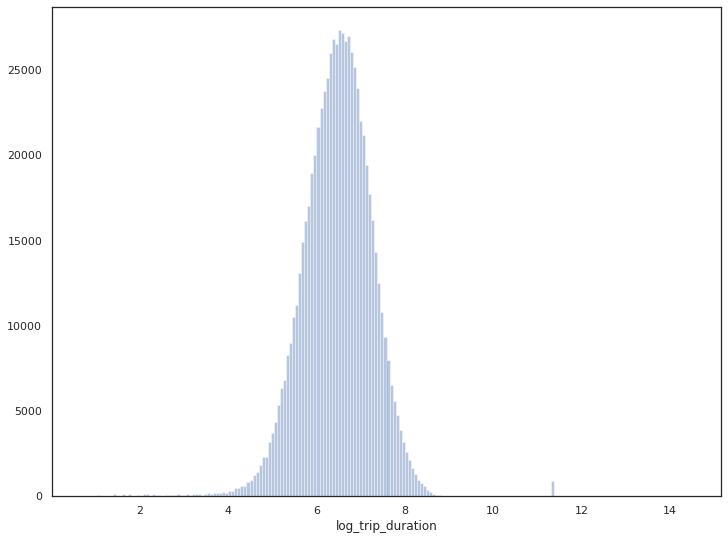

In [10]:
data['log_trip_duration'] = np.log(np.array(data['trip_duration']) + 1)
# Overwrite the current figsize
plt.figure(figsize=(12,9))
sns.distplot(data['log_trip_duration'], bins=200, kde=False);

This is beautiful, notice there are several suspiciously short rides with less than 10 seconds duration. which seem impossible, the vendor should check these driver because they might be gaming the system and there is a huge outlier near 12.

# Feature Analysis & Extraction

## Univariate Visualization on Categorical Features

In [11]:
data.nunique()

id                    729322
vendor_id                  2
pickup_datetime       709359
dropoff_datetime      709308
passenger_count            9
pickup_longitude       19729
pickup_latitude        39776
dropoff_longitude      27892
dropoff_latitude       53579
store_and_fwd_flag         2
trip_duration           6296
log_trip_duration       6296
dtype: int64

In [12]:
cat_cols = []
for col in data:
    if data[col].nunique() < 10:
        cat_cols.append(col)
data[cat_cols].head()

,vendor_id,passenger_count,store_and_fwd_flag
0,2,1,0
1,1,2,0
2,2,2,0
3,2,6,0
4,1,1,0


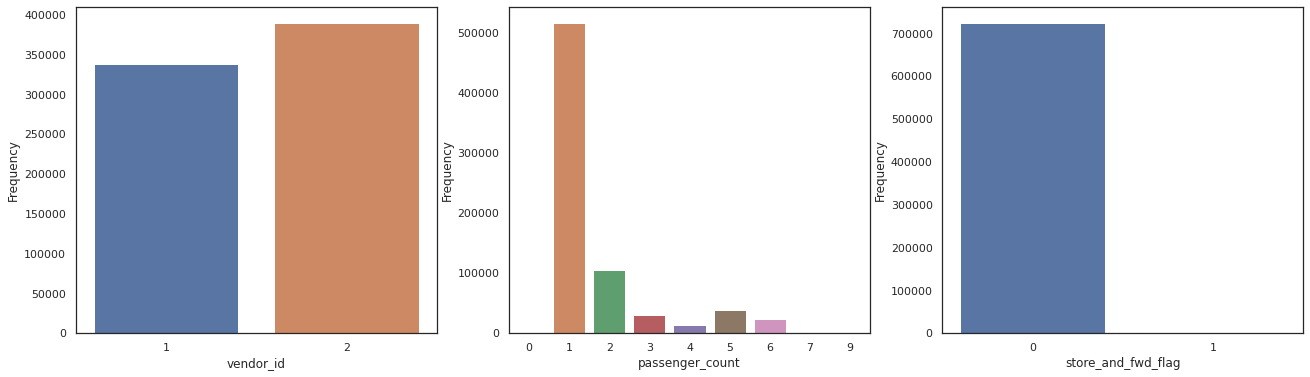

In [13]:
plt.subplot(131)
sns.countplot(data['vendor_id'])
plt.xlabel('vendor_id')
plt.ylabel('Frequency');

plt.subplot(132)
sns.countplot(data['passenger_count'])
plt.xlabel('passenger_count')
plt.ylabel('Frequency');

plt.subplot(133)
sns.countplot(data['store_and_fwd_flag'])
plt.xlabel('store_and_fwd_flag')
plt.ylabel('Frequency');

Observations:
1. Vendor 2 has more number of trip than 1.
2. Majority of the trips involves only 1 passenger.
3. "0" indicates not store and forward while "1" means store and forward. This means there was almost no storing taking place.

## Datetime Features

Now, we will delve into the datetime features to understand the trend of number of hourly/monthly/daily trips.

In [14]:
data.pickup_datetime.min(), data.pickup_datetime.max()

(Timestamp('2016-01-01 00:01:14'), Timestamp('2016-06-30 23:59:37'))

In [15]:
data.dropoff_datetime.min(), data.dropoff_datetime.max()

(Timestamp('2016-01-01 00:05:54'), Timestamp('2016-07-01 23:02:03'))

Clearly, the pickup trips are for 6 months of the year 2016, while the dropoff trips are for 7 months of the year 2016. To look at trends, we first need to extract week days, minutes, and hours of day and timezones from the pickup and dropoff dates.

In [16]:
data['pickup_day_of_week'] = data['pickup_datetime'].dt.dayofweek
data['pickup_day_name'] = data['pickup_datetime'].apply(lambda x: x.day_name())
data['pickup_minute'] = data['pickup_datetime'].dt.minute
data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_month'] = data['pickup_datetime'].dt.month
data['pickup_week_of_year'] = data['pickup_datetime'].dt.weekofyear
data['dropoff_day_of_week'] = data['dropoff_datetime'].dt.dayofweek
data['dropoff_day_name'] = data['dropoff_datetime'].apply(lambda x: x.day_name())
data['dropoff_minute'] = data['dropoff_datetime'].dt.minute
data['dropoff_hour'] = data['dropoff_datetime'].dt.hour
data['dropoff_month'] = data['dropoff_datetime'].dt.month
data['dropoff_week_of_year'] = data['dropoff_datetime'].dt.weekofyear

In [17]:
def get_time_of_day(x):
    
    """Function to calculate 4 timezones,
    
    'Morning' (6:00 am - 11:59 pm)
    'Afternoon' (12:00 pm - 3:59 pm)
    'Evening' (4:00 pm - 9:59 pm)
    'Late Night' (10:00 pm - 5:59 am)
    
    """
    
    if x in range(6, 12):
        return "Morning"
    elif x in range(12, 16):
        return "Afternoon"
    elif x in range(16, 22):
        return "Evening"
    else:
        return "Late_Night"

data['pickup_time_of_day'] = data.pickup_hour.apply(get_time_of_day)
data['dropoff_time_of_day'] = data.dropoff_hour.apply(get_time_of_day)

In [18]:
def get_distance(data):
    
    """Function to calculate the distance between dropoff and pickup 
    coordinates using Haversine formula
    """
    
    pickup = (data.pickup_latitude, data.pickup_longitude)
    dropoff = (data.dropoff_latitude, data.dropoff_longitude)
    return haversine(pickup, dropoff)

data['distance (km)'] = data.apply(lambda x: get_distance(x), axis = 1)

In [19]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_day_of_week,pickup_day_name,pickup_minute,pickup_hour,pickup_month,pickup_week_of_year,dropoff_day_of_week,dropoff_day_name,dropoff_minute,dropoff_hour,dropoff_month,dropoff_week_of_year,pickup_time_of_day,dropoff_time_of_day,distance (km)
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,0,400,5.993961,0,Monday,40,16,2,9,0,Monday,47,16,2,9,Evening,Evening,1.199074
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,0,1100,7.003974,4,Friday,35,23,3,10,4,Friday,53,23,3,10,Late_Night,Late_Night,4.129117
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,0,1635,7.400010,6,Sunday,59,17,2,7,6,Sunday,26,18,2,7,Evening,Evening,7.250763
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,0,1141,7.040536,1,Tuesday,44,9,1,1,1,Tuesday,3,10,1,1,Morning,Morning,2.361101
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,0,848,6.744059,2,Wednesday,42,6,2,7,2,Wednesday,56,6,2,7,Morning,Morning,4.328540


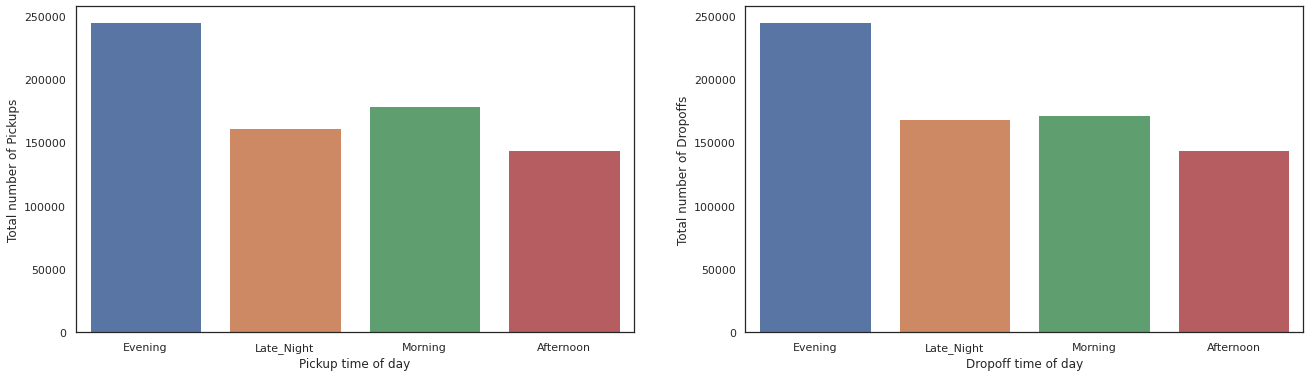

In [20]:
plt.subplot(121)
sns.countplot(data.pickup_time_of_day)
plt.xlabel('Pickup time of day')
plt.ylabel('Total number of Pickups')

plt.subplot(122)
sns.countplot(data.dropoff_time_of_day)
plt.xlabel('Dropoff time of day')
plt.ylabel('Total number of Dropoffs');

- Observe that most pickups and dropoffs trips occurs in the evening when everyone are rushing home

## Pickup Trend

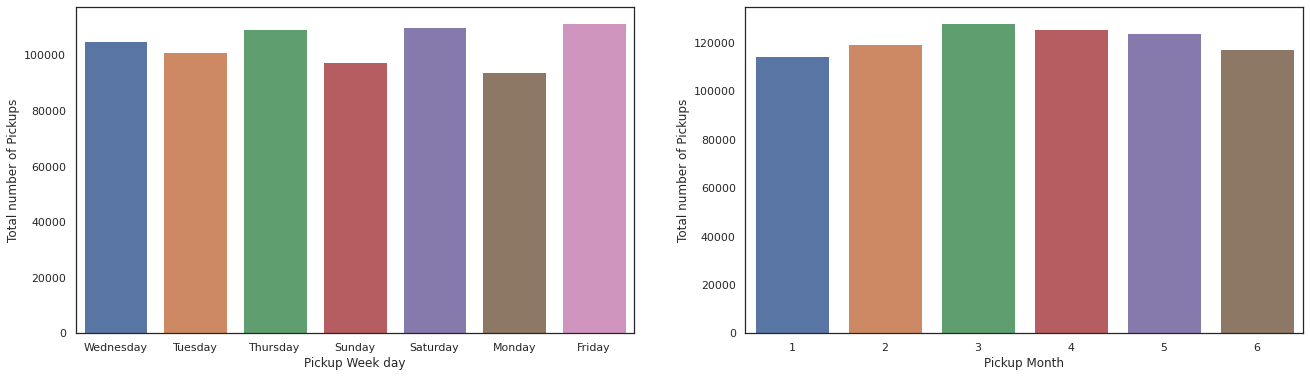

In [21]:
plt.subplot(121)
sns.countplot(data['pickup_day_name'].sort_values(ascending=False))
plt.xlabel('Pickup Week day')
plt.ylabel('Total number of Pickups')

plt.subplot(122)
sns.countplot(data.pickup_month)
plt.xlabel('Pickup Month')
plt.ylabel('Total number of Pickups');

In [22]:
data['pickup_day_name'].value_counts()

Friday       111744
Saturday     110252
Thursday     109344
Wednesday    105074
Tuesday      101254
Sunday        97682
Monday        93972
Name: pickup_day_name, dtype: int64

* The number of pickups as expected is higer in the evening.
* The number of pickups is much higher on Fridays, followed by Saturday and Thursdays .
* The month of March has the highest number of pickups

## Dropoff Trend

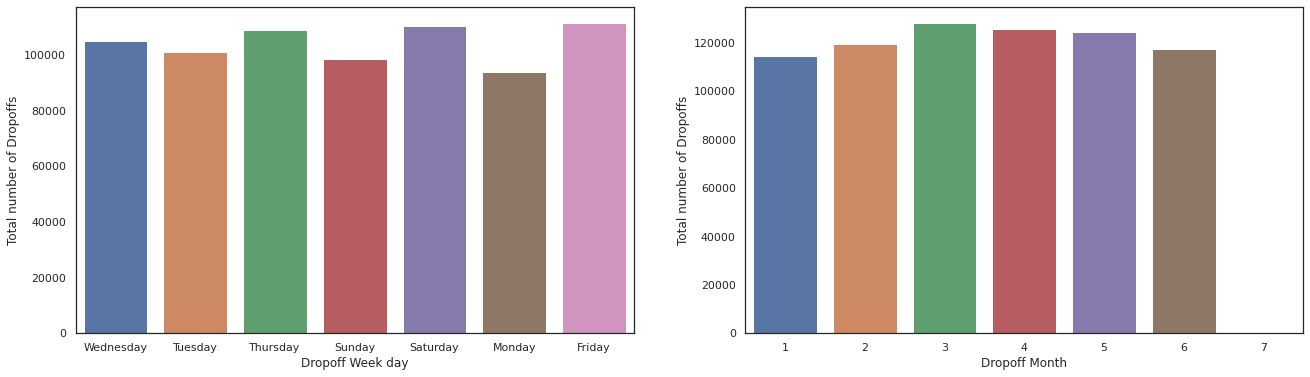

In [23]:
plt.subplot(121)
sns.countplot(data['dropoff_day_name'].sort_values(ascending=False))
plt.xlabel('Dropoff Week day')
plt.ylabel('Total number of Dropoffs')

plt.subplot(122)
sns.countplot(data.dropoff_month)
plt.xlabel('Dropoff Month')
plt.ylabel('Total number of Dropoffs');

- The number of dropoffs trips is same as pickups.
- The month of March is also the highest for dropoffs.

## Latitude and Longitude

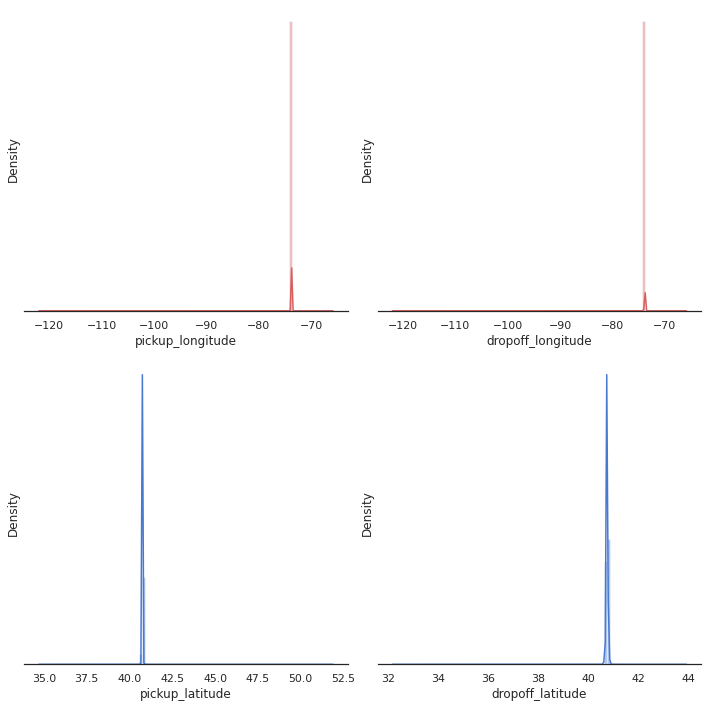

In [24]:
sns.set(style = 'white', palette = 'muted', color_codes = True)
fig, axes = plt.subplots(2, 2, figsize = (10,10), sharex = False, sharey = False)
sns.despine(left = True)

sns.distplot(data.pickup_longitude, color = 'r', label = 'pickup_longitude', bins = 100, ax = axes[0,0])
sns.distplot(data.pickup_latitude, color = 'b', label = 'pickup_latitude', bins = 100, ax = axes[1,0])
sns.distplot(data.dropoff_longitude, color = 'r', label = 'dropoff_longitude', bins = 100, ax = axes[0,1])
sns.distplot(data.dropoff_latitude, color = 'b', label = 'dropoff_latitude', bins = 100, ax = axes[1,1])

plt.setp(axes, yticks = [])
plt.tight_layout()
plt.show()

There are outliers present in both the longitude and latitude. It is clear that the pick and drop latitude are centered around 40 to 41 while for the longitude -73 and -74

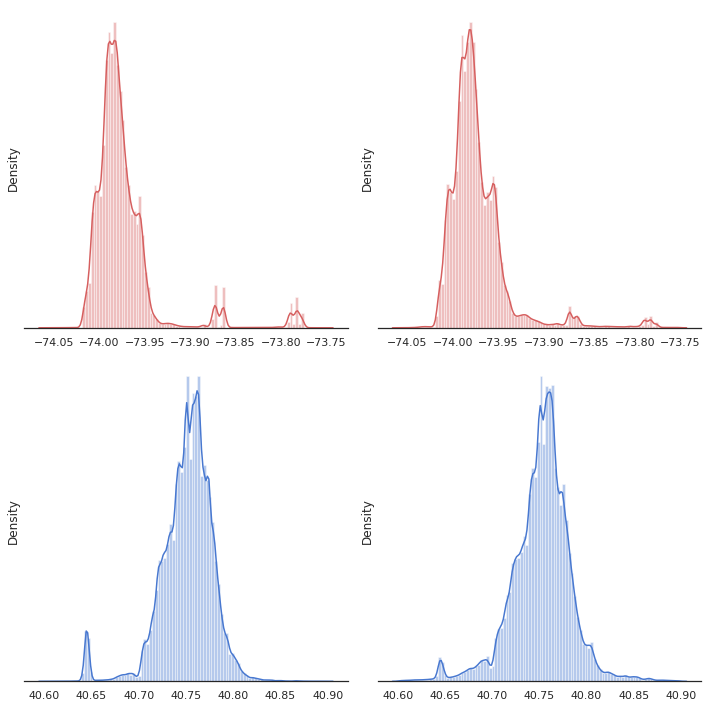

In [25]:
n_pickup_latitude = data.pickup_latitude.loc[(data.pickup_latitude > 40.6) & (data.pickup_latitude < 40.9)]
n_dropoff_latitude = data.dropoff_latitude.loc[(data.dropoff_latitude > 40.6) & (data.dropoff_latitude < 40.9)]
n_pickup_longitude = data.pickup_longitude.loc[(data.pickup_longitude > -74.06) & (data.pickup_longitude < -73.75)]
n_dropoff_longitude = data.dropoff_longitude.loc[(data.dropoff_longitude > -74.06) & (data.dropoff_longitude < -73.75)]

sns.set(style = 'white', palette = 'muted', color_codes = True)
fig, axes = plt.subplots(2, 2, figsize = (10,10), sharex = False, sharey = False)
sns.despine(left = True)

sns.distplot(n_pickup_longitude.values, color = 'r', label = 'pickup_longitude', bins = 100, ax = axes[0,0])
sns.distplot(n_pickup_latitude.values, color = 'b', label = 'pickup_latitude', bins = 100, ax = axes[1,0])
sns.distplot(n_dropoff_longitude.values, color = 'r', label = 'dropoff_longitude', bins = 100, ax = axes[0,1])
sns.distplot(n_dropoff_latitude.values, color = 'b', label = 'dropoff_latitude', bins = 100, ax = axes[1,1])

plt.setp(axes, yticks = [])
plt.tight_layout()
plt.show()

## Check for Missing values

In [26]:
data.isnull().sum()

id                      0
vendor_id               0
pickup_datetime         0
dropoff_datetime        0
passenger_count         0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
store_and_fwd_flag      0
trip_duration           0
log_trip_duration       0
pickup_day_of_week      0
pickup_day_name         0
pickup_minute           0
pickup_hour             0
pickup_month            0
pickup_week_of_year     0
dropoff_day_of_week     0
dropoff_day_name        0
dropoff_minute          0
dropoff_hour            0
dropoff_month           0
dropoff_week_of_year    0
pickup_time_of_day      0
dropoff_time_of_day     0
distance (km)           0
dtype: int64

We have a much better view of the distribution of the coordinates with most trips in longitude and latitude.

# Bivariate relationship with Target variable (Trip duration)

In [27]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_day_of_week,pickup_day_name,pickup_minute,pickup_hour,pickup_month,pickup_week_of_year,dropoff_day_of_week,dropoff_day_name,dropoff_minute,dropoff_hour,dropoff_month,dropoff_week_of_year,pickup_time_of_day,dropoff_time_of_day,distance (km)
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,0,400,5.993961,0,Monday,40,16,2,9,0,Monday,47,16,2,9,Evening,Evening,1.199074
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,0,1100,7.003974,4,Friday,35,23,3,10,4,Friday,53,23,3,10,Late_Night,Late_Night,4.129117
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,0,1635,7.400010,6,Sunday,59,17,2,7,6,Sunday,26,18,2,7,Evening,Evening,7.250763
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,0,1141,7.040536,1,Tuesday,44,9,1,1,1,Tuesday,3,10,1,1,Morning,Morning,2.361101
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,0,848,6.744059,2,Wednesday,42,6,2,7,2,Wednesday,56,6,2,7,Morning,Morning,4.328540


## Trip duration vs Distance

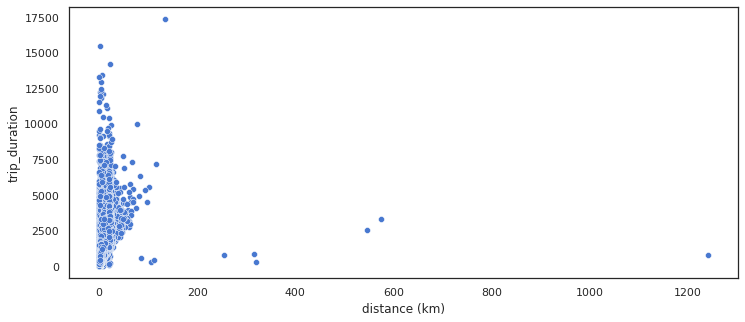

In [28]:
plt.figure(figsize=(12,5))
data_dst = data[data['trip_duration'] < 1.84*10000]
sns.scatterplot(x = 'distance (km)', y = 'trip_duration', data = data_dst);

We can see several outliers with values much more beyond 200km, and many values with trip_distance = 0km.

In [29]:
print(f"They are {data['distance (km)'].loc[data['distance (km)'] == 0].count()} trip records with 0 km distance")

They are 2901 trip records with 0 km distance


There are 2901 trips with distance equal 0. Which means:
- Customer cancelled the journey just after accepting it.
- Driver cancelled the trip just after accepting due to some reasons

In [30]:
# Let's replace these distance of 0km with it's average distance
mean_dist = data['distance (km)'].mean()
data.loc[data['distance (km)'] == 0, 'distance (km)'] = mean_dist

We will create a new feature called speed so as to enable us to identify the time taken and distance covered does not match up.

In [31]:
data['trip_duration_hour'] = data.trip_duration / 3600
data['speed (km/h)'] = data['distance (km)'] / data['trip_duration_hour']

In [32]:
# The average speed is 12.8km/h
print(f"The average speed is {data['speed (km/h)'].median():.2f} km/h")

The average speed is 12.85 km/h


In [33]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_day_of_week,pickup_day_name,pickup_minute,pickup_hour,pickup_month,pickup_week_of_year,dropoff_day_of_week,dropoff_day_name,dropoff_minute,dropoff_hour,dropoff_month,dropoff_week_of_year,pickup_time_of_day,dropoff_time_of_day,distance (km),trip_duration_hour,speed (km/h)
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,0,400,5.993961,0,Monday,40,16,2,9,0,Monday,47,16,2,9,Evening,Evening,1.199074,0.111111,10.791668
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,0,1100,7.003974,4,Friday,35,23,3,10,4,Friday,53,23,3,10,Late_Night,Late_Night,4.129117,0.305556,13.513473
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,0,1635,7.400010,6,Sunday,59,17,2,7,6,Sunday,26,18,2,7,Evening,Evening,7.250763,0.454167,15.964983
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,0,1141,7.040536,1,Tuesday,44,9,1,1,1,Tuesday,3,10,1,1,Morning,Morning,2.361101,0.316944,7.449573
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,0,848,6.744059,2,Wednesday,42,6,2,7,2,Wednesday,56,6,2,7,Morning,Morning,4.328540,0.235556,18.375877


In [34]:
j = pd.DataFrame({'trip_duration_hour': (data['trip_duration_hour']*5),
                  'distance': data['distance (km)']/10
                 })

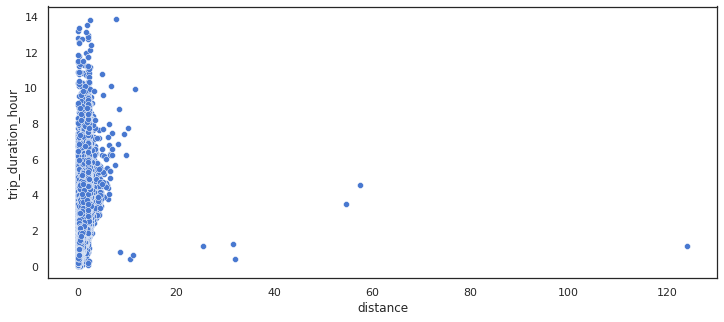

In [35]:
plt.figure(figsize=(12,5))
j = j[j['trip_duration_hour'] < 14]
sns.scatterplot(x = 'distance', y = 'trip_duration_hour', data = j);

Here we can see several data points were the distance is < 20km and the time is > 12hours, this is very absurd as the average speed is 12.85 km/h. This might be due to road congestion. Let's log transform and take a look again

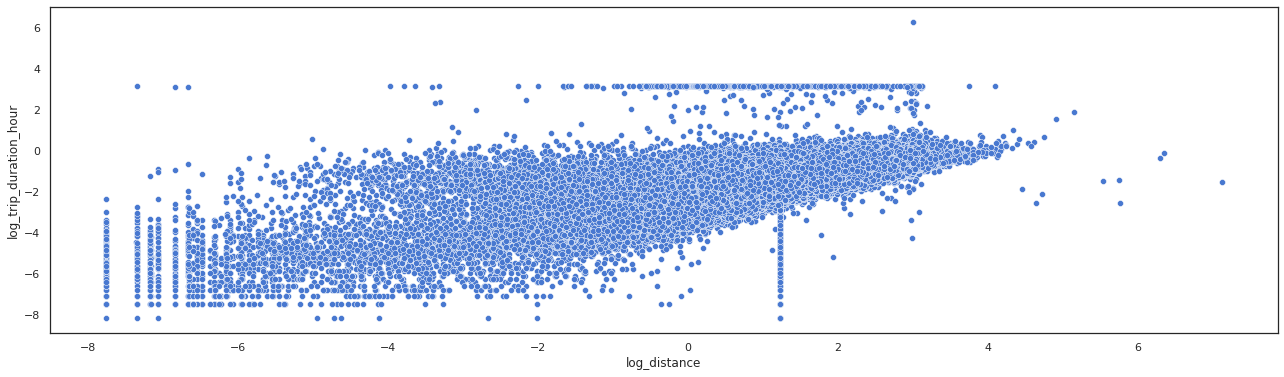

In [36]:
data['log_distance']=np.log(data['distance (km)'])
data['log_trip_duration_hour']=np.log(data['trip_duration_hour'])

sns.scatterplot(x ='log_distance',y = 'log_trip_duration_hour',data = data);

It seem to be linearly distributed, although there are still some data point that does not still changes.

## Trip duration vs Month

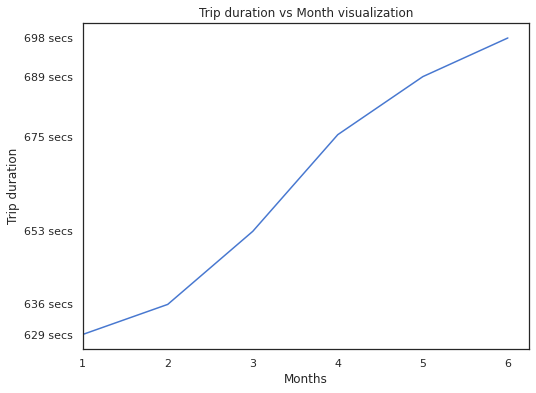

In [37]:
summary_month_avg_duration = pd.DataFrame(data.groupby(['pickup_month'])['trip_duration'].median()) # we use median inplace of mean cause of the presence of outliers
summary_month_avg_duration.reset_index(inplace = True)

fig, axes = plt.subplots(figsize=(8,6))
axes.plot(summary_month_avg_duration['pickup_month'], summary_month_avg_duration['trip_duration'])
ytick = [int(dur) for dur in summary_month_avg_duration['trip_duration']]
ytick_label = [str(int(dur))+' secs' for dur in summary_month_avg_duration['trip_duration']]

plt.setp(axes, yticks = ytick, yticklabels = ytick_label)
axes.set_xlim(left=1)
axes.set_xlabel('Months')
axes.set_ylabel('Trip duration')
axes.set_title('Trip duration vs Month visualization')
plt.show()

It can be seen that there is a rise in the trip duration from the month of Febuary(2) to May(5)

## Trip duration vs Time of day

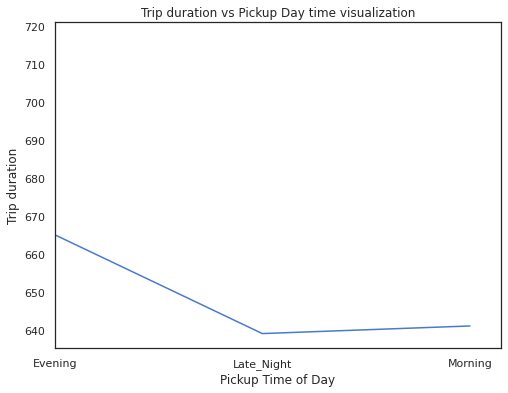

In [38]:
summary_daytime_avg_duration = pd.DataFrame(data.groupby(['pickup_time_of_day'])['trip_duration'].median())
summary_daytime_avg_duration.reset_index(inplace = True)

fig, axes = plt.subplots(figsize=(8,6))
axes.plot(summary_daytime_avg_duration['pickup_time_of_day'], summary_daytime_avg_duration['trip_duration'])

axes.set_xlim(left=1)
axes.set_xlabel('Pickup Time of Day')
axes.set_ylabel('Trip duration')
axes.set_title('Trip duration vs Pickup Day time visualization')
plt.show()

- Trip durations are higher at evening time and rise towards morning.
- It follows a similar pattern when compared to number of pickups indicating a correlation between number of pickups and trip duration

## Trip duration vs Hour

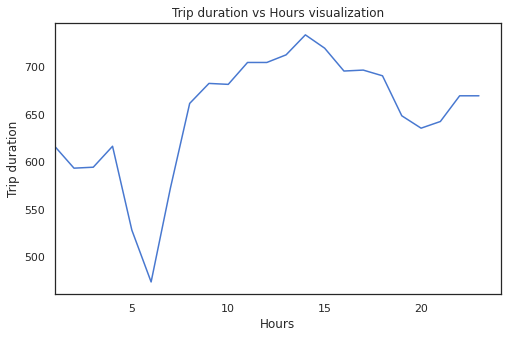

In [39]:
summary_hour_avg_duration = pd.DataFrame(data.groupby(['pickup_hour'])['trip_duration'].median())
summary_hour_avg_duration.reset_index(inplace = True)

fig, axes = plt.subplots(figsize=(8,5))
axes.plot(summary_hour_avg_duration['pickup_hour'], summary_hour_avg_duration['trip_duration'])

axes.set_xlim(left=1)
axes.set_xlabel('Hours')
axes.set_ylabel('Trip duration')
axes.set_title('Trip duration vs Hours visualization')
plt.show()

* Trip durations are shorter for late night and early morning hours.

## Trip duration vs Weekday

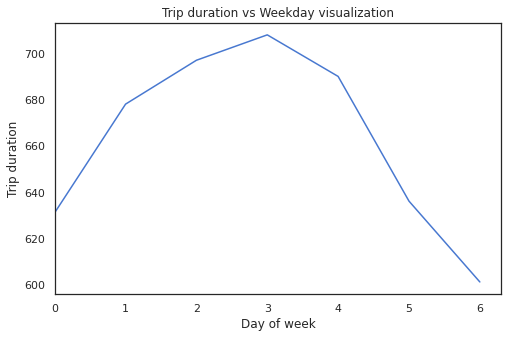

In [40]:
summary_day_avg_duration = pd.DataFrame(data.groupby(['pickup_day_of_week'])['trip_duration'].median())
summary_day_avg_duration.reset_index(inplace = True)

fig, axes = plt.subplots(figsize=(8,5))
axes.plot(summary_day_avg_duration['pickup_day_of_week'], summary_day_avg_duration['trip_duration'])

axes.set_xlim(left=0)
axes.set_xlabel('Day of week')
axes.set_ylabel('Trip duration')
axes.set_title('Trip duration vs Weekday visualization')
plt.show()

The trip duration peaks on Wednessdays and thursdays, while weekend seems to have the shortest trip duration.

## Trip duration vs vendor_id

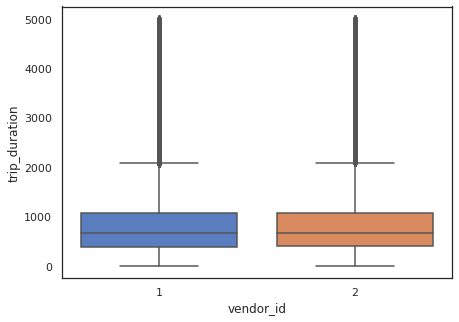

In [41]:
plt.figure(figsize=(7,5))
data_id = data[data.trip_duration < 5000]
sns.boxplot(x = 'vendor_id', y = 'trip_duration', data=data_id);

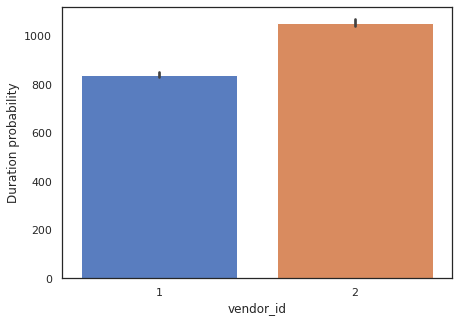

In [42]:
plt.figure(figsize=(7,5))
c = sns.barplot(x = 'vendor_id', y = 'trip_duration', data=data)
c.set_ylabel('Duration probability');

It can be seen that vendor 2 has more number of trips as compared to 1.

## Trip duration vs passenger_count

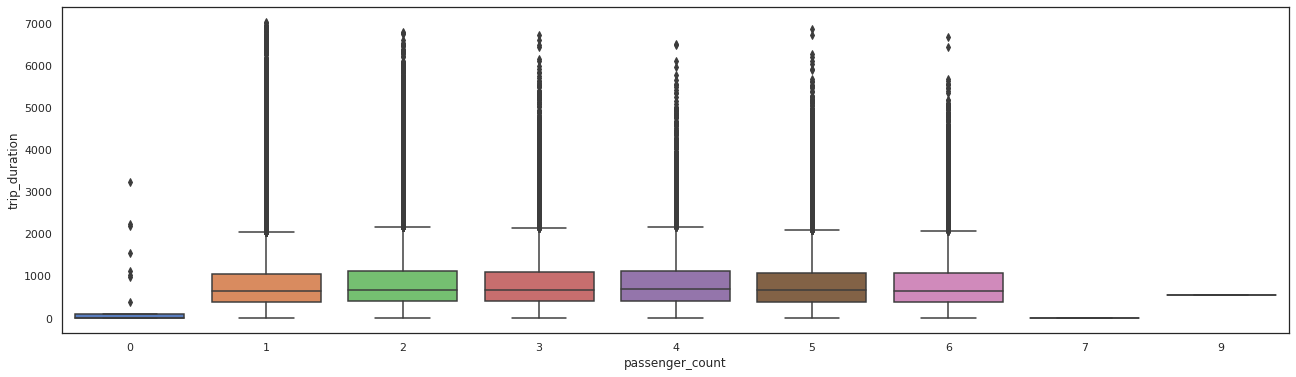

In [43]:
data_count = data[data.trip_duration < 7050]
sns.boxplot(x = 'passenger_count', y = 'trip_duration', data=data_count);

- The boxplot clearly shows that there are not much of a difference in distribution for the most frequently occuring passenger count.
- Another key observation is that the number of outliers are reduced for higher passenger counts but that only comes down to the individual frequencies of each passenger count.

## Trip duration vs store_and_fwd_flag

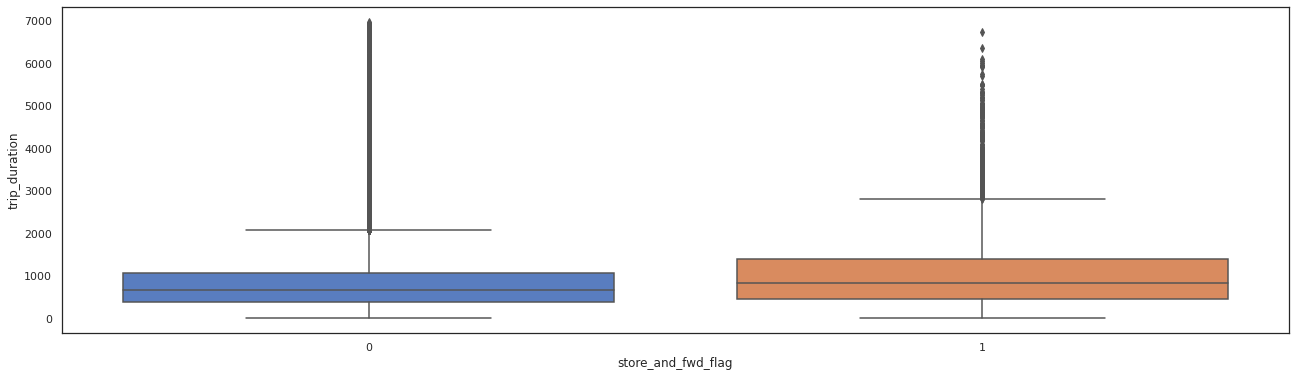

In [44]:
data_flag = data[data.trip_duration < 6990]
sns.boxplot(x = 'store_and_fwd_flag', y = 'trip_duration', data=data_flag);

- The trip duration is less for the flag 0 i.e trip records that were store and not forward immediately.
- The trip duration is longer for the flag 1 which is a store and forward trip

## Visualize the most frequently occuring points on the logitude, latitude map

### New York City Pickup Location

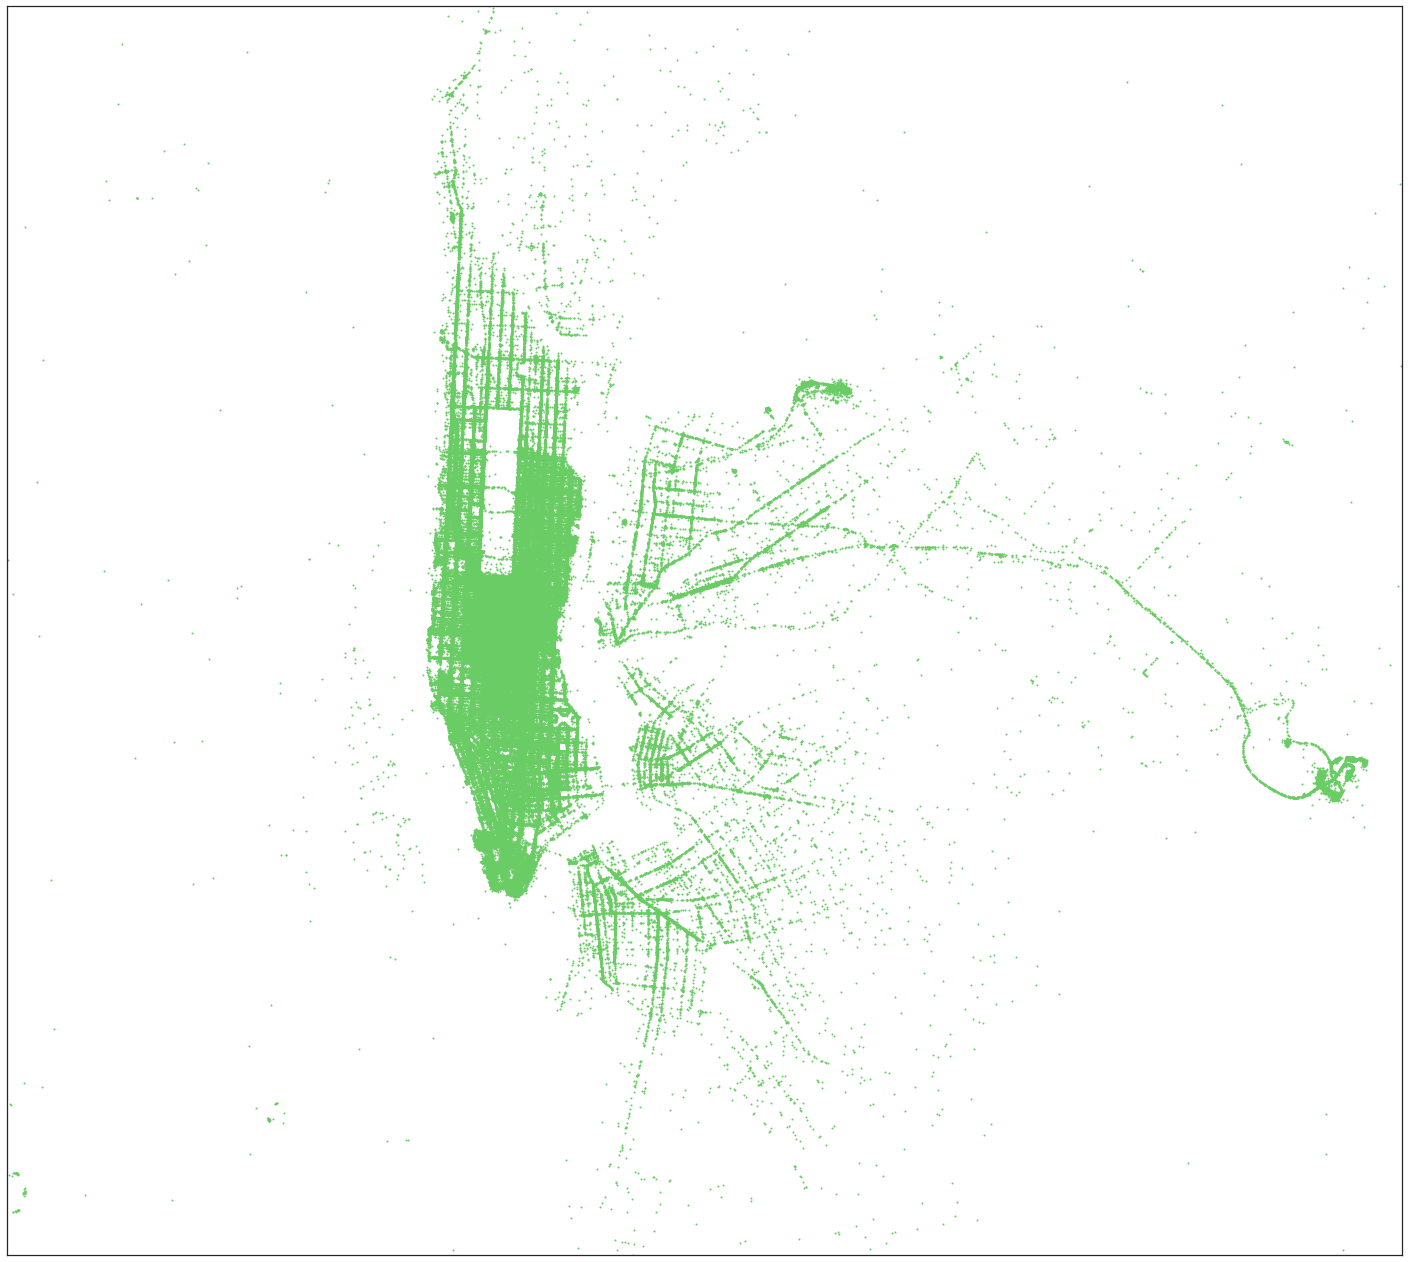

In [45]:
fig, ax = plt.subplots(figsize=(25,25))

# Set the limits of the map to the maximum and minimum coordinates
lat_min = 40.68
lat_max = 40.79
lon_min = -74.19
lon_max = -73.67

# Set the center of the map
center_lon = lon_min + lon_max / 2
center_lat = lat_min + lat_max / 2



# Create the basemap object
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            resolution='l',
            projection='tmerc',
            lat_0=center_lat,
            lon_0=center_lon)

## Style the map
# m.drawmapboundary()
# m.drawcoastlines()
# m.fillcontinents()
# m.drawcountries(linewidth=2)
# m.drawstates()

long = np.array(data['pickup_longitude'])
lat = np.array(data['pickup_latitude'])

x, y = m(long, lat)
m.plot(x, y, 'go', markersize=1, alpha=1)

plt.show()

- We can see that most of the pickups were done in the Manhattan area of New york and the airport as compared to other areas.

### New York City Dropoff Location

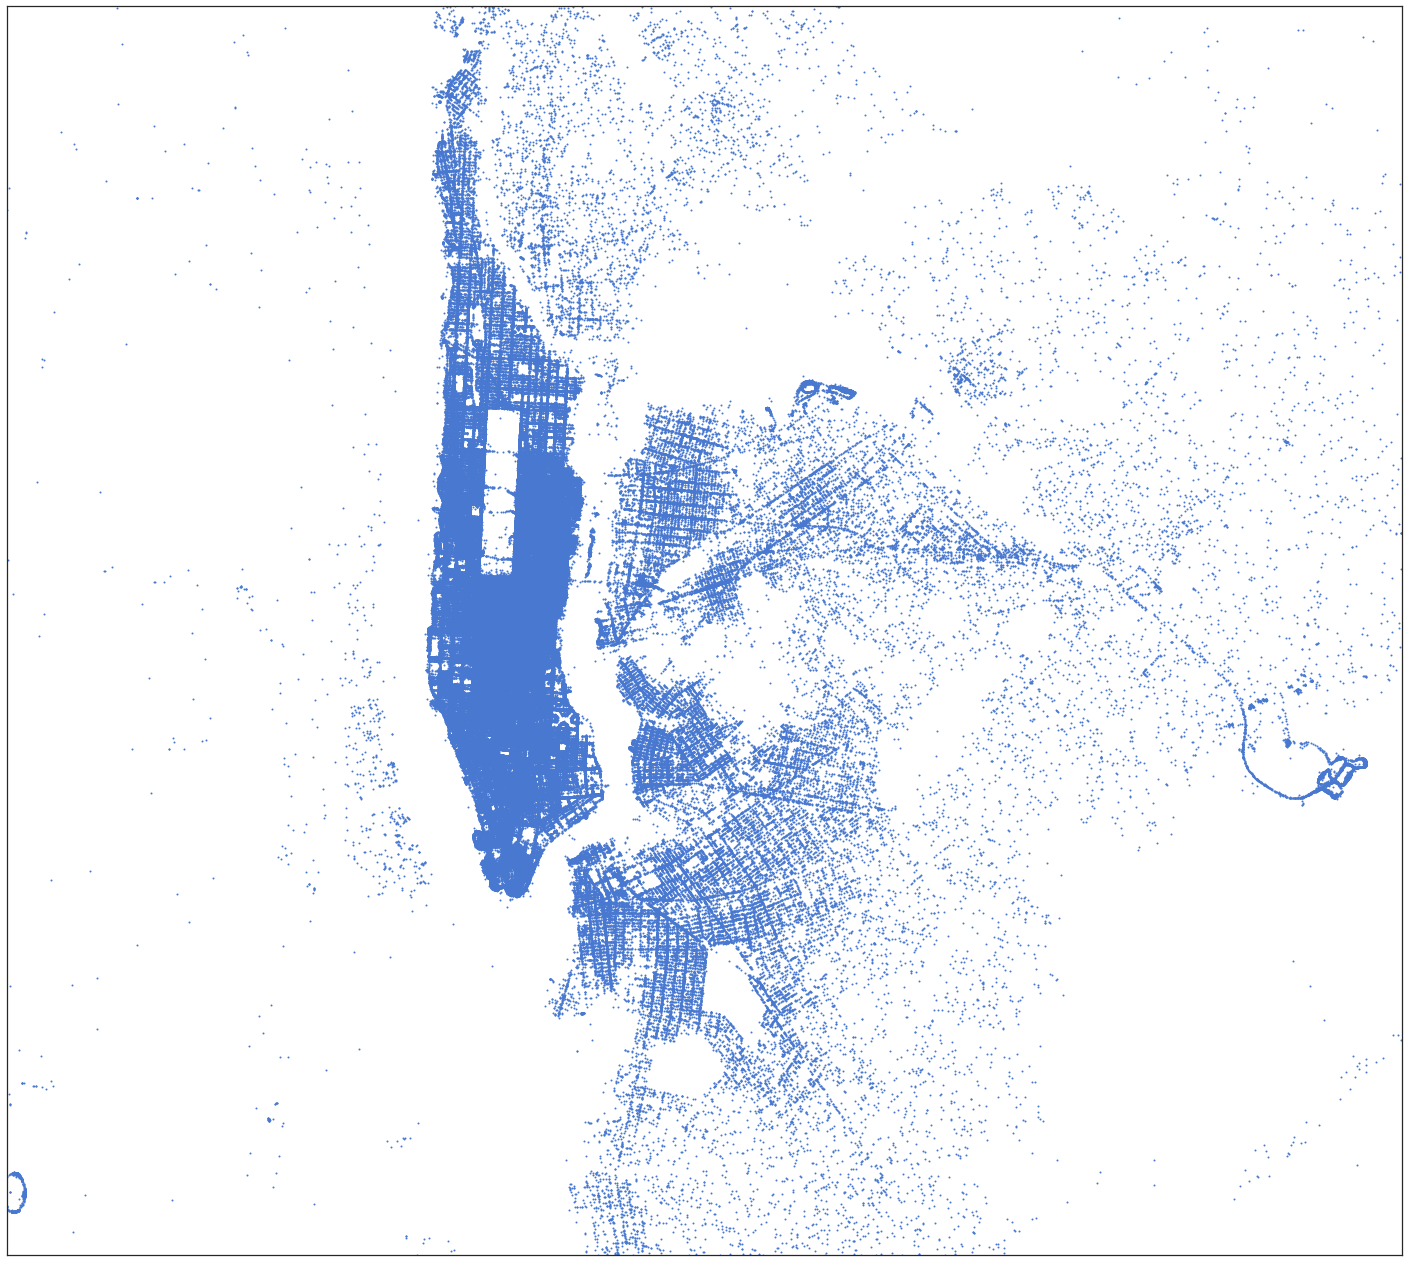

In [46]:
fig, ax = plt.subplots(figsize=(25,25))

# Set the limits of the map to the maximum and minimum coordinates
lat_min = 40.68
lat_max = 40.79
lon_min = -74.19
lon_max = -73.67

# Set the center of the map
center_lon = lon_min + lon_max / 2
center_lat = lat_min + lat_max / 2



# Create the basemap object
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            resolution='l',
            projection='tmerc',
            lat_0=center_lat,
            lon_0=center_lon)

long = np.array(data['dropoff_longitude'])
lat = np.array(data['dropoff_latitude'])

x, y = m(long, lat)
m.plot(x, y, 'bo', markersize=1, alpha=1)

plt.show()

- Most dropoffs again occured in the manhattan area, close to manhattan and the airport.

In [47]:
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'log_trip_duration', 'pickup_day_of_week',
       'pickup_day_name', 'pickup_minute', 'pickup_hour', 'pickup_month',
       'pickup_week_of_year', 'dropoff_day_of_week', 'dropoff_day_name',
       'dropoff_minute', 'dropoff_hour', 'dropoff_month',
       'dropoff_week_of_year', 'pickup_time_of_day', 'dropoff_time_of_day',
       'distance (km)', 'trip_duration_hour', 'speed (km/h)', 'log_distance',
       'log_trip_duration_hour'],
      dtype='object')

In [48]:
data.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration',
           'trip_duration_hour', 'pickup_day_name', 'dropoff_day_name', 'log_trip_duration_hour'], 
          axis = 1, inplace = True)

data_cleaned = data.copy()

In [49]:
data_cleaned.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,pickup_day_of_week,pickup_minute,pickup_hour,pickup_month,pickup_week_of_year,dropoff_day_of_week,dropoff_minute,dropoff_hour,dropoff_month,dropoff_week_of_year,pickup_time_of_day,dropoff_time_of_day,distance (km),speed (km/h),log_distance
0,2,1,-73.953918,40.778873,-73.963875,40.771164,0,5.993961,0,40,16,2,9,0,47,16,2,9,Evening,Evening,1.199074,10.791668,0.181550
1,1,2,-73.988312,40.731743,-73.994751,40.694931,0,7.003974,4,35,23,3,10,4,53,23,3,10,Late_Night,Late_Night,4.129117,13.513473,1.418064
2,2,2,-73.997314,40.721458,-73.948029,40.774918,0,7.400010,6,59,17,2,7,6,26,18,2,7,Evening,Evening,7.250763,15.964983,1.981107
3,2,6,-73.961670,40.759720,-73.956779,40.780628,0,7.040536,1,44,9,1,1,1,3,10,1,1,Morning,Morning,2.361101,7.449573,0.859128
4,1,1,-74.017120,40.708469,-73.988182,40.740631,0,6.744059,2,42,6,2,7,2,56,6,2,7,Morning,Morning,4.328540,18.375877,1.465230


# Feature Engineering

In [50]:
data_cleaned.nunique()

vendor_id                    2
passenger_count              9
pickup_longitude         19729
pickup_latitude          39776
dropoff_longitude        27892
dropoff_latitude         53579
store_and_fwd_flag           2
log_trip_duration         6296
pickup_day_of_week           7
pickup_minute               60
pickup_hour                 24
pickup_month                 6
pickup_week_of_year         27
dropoff_day_of_week          7
dropoff_minute              60
dropoff_hour                24
dropoff_month                7
dropoff_week_of_year        27
pickup_time_of_day           4
dropoff_time_of_day          4
distance (km)           726199
speed (km/h)            727523
log_distance            726199
dtype: int64

**One-hot Encode the nominal variables and label Encode the ordinal features**

In [51]:
data_cleaned.pickup_time_of_day.value_counts()

Evening       245336
Morning       178666
Late_Night    161063
Afternoon     144257
Name: pickup_time_of_day, dtype: int64

In [52]:
data_cleaned['pickup_time_of_day'] = data_cleaned['pickup_time_of_day'].map({'Evening': 0,
                                                                            'Morning': 1,
                                                                            'Late_Night': 2,
                                                                            'Afternoon': 3})

In [53]:
data_cleaned['dropoff_time_of_day'] = data_cleaned['dropoff_time_of_day'].map({'Evening': 0,
                                                                            'Morning': 1,
                                                                            'Late_Night': 2,
                                                                            'Afternoon': 3})

In [54]:
data_cleaned.vendor_id.value_counts()

2    390481
1    338841
Name: vendor_id, dtype: int64

In [55]:
data_cleaned.passenger_count.value_counts()

1    517415
2    105097
5     38926
3     29692
6     24107
4     14050
0        33
7         1
9         1
Name: passenger_count, dtype: int64

We have to drop 0, 7 and 9 passengers which seem absurd as they cannot be 0, 7 or 9 passengers to occupy one taxi.

In [56]:
data_cleaned = data_cleaned[data_cleaned.passenger_count <= 6]
data_cleaned = data_cleaned[data_cleaned.passenger_count != 0]
data.shape

(729322, 23)

In [57]:
data_cleaned.passenger_count.value_counts()

1    517415
2    105097
5     38926
3     29692
6     24107
4     14050
Name: passenger_count, dtype: int64

In [58]:
data_cleaned.store_and_fwd_flag.value_counts()

0    725249
1      4038
Name: store_and_fwd_flag, dtype: int64

In [59]:
data_cleaned.pickup_day_of_week.value_counts()

4    111737
5    110247
3    109340
2    105072
1    101252
6     97672
0     93967
Name: pickup_day_of_week, dtype: int64

***We are going to one-hot encode these features (vendor_id, passenger_count, store_and_flag, pickup_month, dropoff_month) as they are nominal variables***

In [60]:
data_cleaned = pd.get_dummies(data = data_cleaned, columns = ['vendor_id', 'passenger_count','store_and_fwd_flag',
                                                              'pickup_month','dropoff_month','pickup_time_of_day',
                                                              'dropoff_time_of_day', 'pickup_day_of_week', 
                                                              'dropoff_day_of_week'])
print(data_cleaned.shape)
data_cleaned.head()

(729287, 59)


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,log_trip_duration,pickup_minute,pickup_hour,pickup_week_of_year,dropoff_minute,dropoff_hour,dropoff_week_of_year,distance (km),speed (km/h),log_distance,vendor_id_1,vendor_id_2,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,store_and_fwd_flag_0,store_and_fwd_flag_1,pickup_month_1,pickup_month_2,pickup_month_3,pickup_month_4,pickup_month_5,pickup_month_6,dropoff_month_1,dropoff_month_2,dropoff_month_3,dropoff_month_4,dropoff_month_5,dropoff_month_6,dropoff_month_7,pickup_time_of_day_0,pickup_time_of_day_1,pickup_time_of_day_2,pickup_time_of_day_3,dropoff_time_of_day_0,dropoff_time_of_day_1,dropoff_time_of_day_2,dropoff_time_of_day_3,pickup_day_of_week_0,pickup_day_of_week_1,pickup_day_of_week_2,pickup_day_of_week_3,pickup_day_of_week_4,pickup_day_of_week_5,pickup_day_of_week_6,dropoff_day_of_week_0,dropoff_day_of_week_1,dropoff_day_of_week_2,dropoff_day_of_week_3,dropoff_day_of_week_4,dropoff_day_of_week_5,dropoff_day_of_week_6
0,-73.953918,40.778873,-73.963875,40.771164,5.993961,40,16,9,47,16,9,1.199074,10.791668,0.181550,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,-73.988312,40.731743,-73.994751,40.694931,7.003974,35,23,10,53,23,10,4.129117,13.513473,1.418064,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,-73.997314,40.721458,-73.948029,40.774918,7.400010,59,17,7,26,18,7,7.250763,15.964983,1.981107,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,-73.961670,40.759720,-73.956779,40.780628,7.040536,44,9,1,3,10,1,2.361101,7.449573,0.859128,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,-74.017120,40.708469,-73.988182,40.740631,6.744059,42,6,7,56,6,7,4.328540,18.375877,1.465230,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


The longitude and latitude may be a bit noisy so let's round them up to 3 decimal place as new features.

In [61]:
data_cleaned['pickup_longitude_round3'] = np.round(data_cleaned['pickup_longitude'], 3)
data_cleaned['pickup_latitude_round3'] = np.round(data_cleaned['pickup_latitude'], 3)
data_cleaned['dropoff_longitude_round3'] = np.round(data_cleaned['dropoff_longitude'], 3)
data_cleaned['dropoff_latitude_round3'] = np.round(data_cleaned['dropoff_latitude'], 3)

data_cleaned.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], 
                  axis = 1, inplace = True)

In [62]:
y = data_cleaned['log_trip_duration']
all_feats = data_cleaned.drop(['log_trip_duration'], axis = 1)
all_feats_checkpoint = all_feats.copy()
data_cleaned.head()

,log_trip_duration,pickup_minute,pickup_hour,pickup_week_of_year,dropoff_minute,dropoff_hour,dropoff_week_of_year,distance (km),speed (km/h),log_distance,vendor_id_1,vendor_id_2,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,store_and_fwd_flag_0,store_and_fwd_flag_1,pickup_month_1,pickup_month_2,pickup_month_3,pickup_month_4,pickup_month_5,pickup_month_6,dropoff_month_1,dropoff_month_2,dropoff_month_3,dropoff_month_4,dropoff_month_5,dropoff_month_6,dropoff_month_7,pickup_time_of_day_0,pickup_time_of_day_1,pickup_time_of_day_2,pickup_time_of_day_3,dropoff_time_of_day_0,dropoff_time_of_day_1,dropoff_time_of_day_2,dropoff_time_of_day_3,pickup_day_of_week_0,pickup_day_of_week_1,pickup_day_of_week_2,pickup_day_of_week_3,pickup_day_of_week_4,pickup_day_of_week_5,pickup_day_of_week_6,dropoff_day_of_week_0,dropoff_day_of_week_1,dropoff_day_of_week_2,dropoff_day_of_week_3,dropoff_day_of_week_4,dropoff_day_of_week_5,dropoff_day_of_week_6,pickup_longitude_round3,pickup_latitude_round3,dropoff_longitude_round3,dropoff_latitude_round3
0,5.993961,40,16,9,47,16,9,1.199074,10.791668,0.181550,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,-73.954,40.779,-73.964,40.771
1,7.003974,35,23,10,53,23,10,4.129117,13.513473,1.418064,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,-73.988,40.732,-73.995,40.695
2,7.400010,59,17,7,26,18,7,7.250763,15.964983,1.981107,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,-73.997,40.721,-73.948,40.775
3,7.040536,44,9,1,3,10,1,2.361101,7.449573,0.859128,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,-73.962,40.760,-73.957,40.781
4,6.744059,42,6,7,56,6,7,4.328540,18.375877,1.465230,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,-74.017,40.708,-73.988,40.741


## Correlation

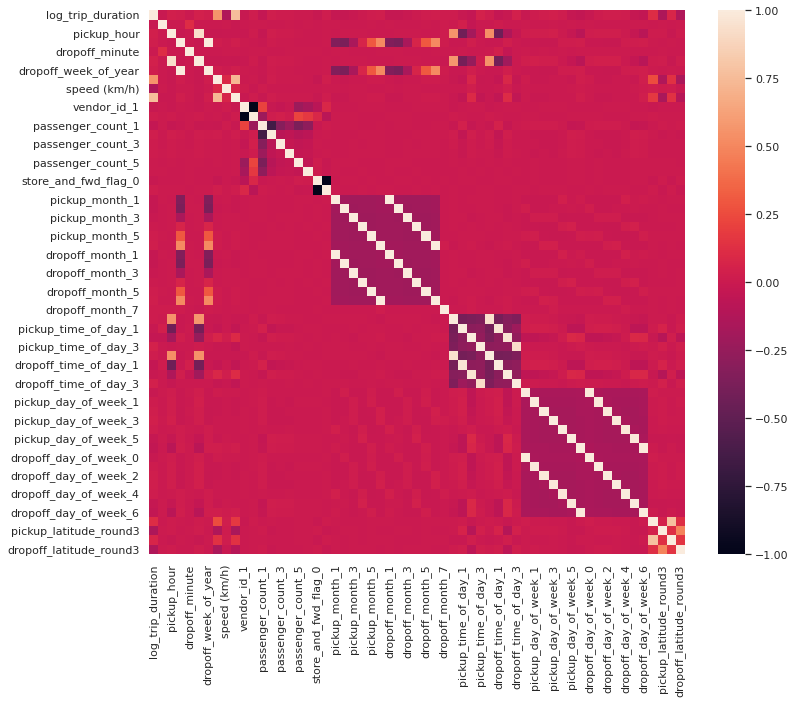

In [63]:
plt.figure(figsize=(12, 10))
corr_matrix = data_cleaned.corr()
sns.heatmap(corr_matrix);

In [64]:
corr_matrix.log_trip_duration.sort_values(ascending=False)

log_trip_duration           1.000000
log_distance                0.758337
distance (km)               0.561989
pickup_longitude_round3     0.112349
dropoff_longitude_round3    0.073014
pickup_time_of_day_3        0.051397
dropoff_time_of_day_3       0.043482
dropoff_hour                0.039100
pickup_hour                 0.038793
pickup_day_of_week_3        0.031846
dropoff_day_of_week_3       0.030002
pickup_month_6              0.028832
dropoff_month_6             0.028698
pickup_week_of_year         0.027952
dropoff_week_of_year        0.027653
dropoff_day_of_week_2       0.025313
passenger_count_2           0.025262
pickup_day_of_week_2        0.025257
dropoff_month_5             0.022689
pickup_month_5              0.022529
vendor_id_2                 0.019464
pickup_day_of_week_4        0.019125
dropoff_day_of_week_4       0.018131
dropoff_time_of_day_0       0.017851
store_and_fwd_flag_1        0.016584
passenger_count_3           0.013203
dropoff_month_7             0.012958
p

In [65]:
baseline_feats = data_cleaned[['log_distance', 'distance (km)', 'pickup_longitude_round3',
                               'dropoff_longitude_round3', 'pickup_time_of_day_3', 'dropoff_time_of_day_3',
                               'dropoff_hour', 'pickup_hour', 'pickup_day_of_week_3', 'dropoff_day_of_week_3', 
                               'pickup_month_6', 'dropoff_month_6','pickup_week_of_year', 'dropoff_week_of_year',
                               'dropoff_day_of_week_2','passenger_count_2', 'pickup_day_of_week_2',
                               'dropoff_month_5', 'pickup_month_5', 'vendor_id_2', 'pickup_day_of_week_4', 
                               'dropoff_day_of_week_4', 'dropoff_time_of_day_0','store_and_fwd_flag_1', 
                               'passenger_count_3', 'dropoff_month_7','pickup_day_of_week_1', 
                               'dropoff_day_of_week_1','passenger_count_4']]

In [66]:
baseline_feats.head()
baseline_feats_checkpoint = baseline_feats.copy()

**Now, we have the all_features and baseline_features. We will check for multicollinearity in both dataframe to see the relevant features for our linear models. So we can train them on the relevant ones.**

## Check for Multicollinearity

**Common ways to check for Multicollinearity**
1. VIF = 1, Very less Multicollinearity
2. VIF < 5, Moderate Multicollinearity
3. VIF > 5, Extreme Multicollinearity (This is what we want to avoid)

### Baseline features Dataframe

In [67]:
def calculate_VIF(data):
    
    """Function to calculte the presence of Multicollinearity between independent features"""
    
    vif_df = pd.DataFrame(columns = ['Var', 'VIF'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1 / (1-r_squared), 2)
        vif_df.loc[i] = [x_var_names[i], vif]
        
    return vif_df.sort_values(by = 'VIF', axis = 0, ascending = False, inplace = False)

calculate_VIF(baseline_feats)

,Var,VIF
3,dropoff_longitude_round3,2701060.10
2,pickup_longitude_round3,2700267.64
13,dropoff_week_of_year,2624.08
12,pickup_week_of_year,2620.66
6,dropoff_hour,48.12
7,pickup_hour,46.94
10,pickup_month_6,8.52
11,dropoff_month_6,7.10
25,dropoff_month_7,3.93
0,log_distance,3.78


In [68]:
%%time
# Filter the features with high Multicollinearity
base_no_multicol = baseline_feats.drop(['dropoff_longitude_round3', 'pickup_longitude_round3', 
                                        'pickup_week_of_year', 'dropoff_week_of_year', 
                                        'dropoff_hour', 'pickup_hour', 'pickup_month_6'], axis = 1)
calculate_VIF(base_no_multicol)

CPU times: user 2min 55s, sys: 39.6 s, total: 3min 35s
Wall time: 1min 14s


,Var,VIF
0,log_distance,3.63
1,distance (km),3.51
18,dropoff_month_7,1.03
10,dropoff_month_5,0.79
11,pickup_month_5,0.40
7,dropoff_day_of_week_2,0.29
19,pickup_day_of_week_1,0.13
9,pickup_day_of_week_2,0.13
5,dropoff_day_of_week_3,0.11
14,dropoff_day_of_week_4,0.08


## All_features Dataframe

In [69]:
%%time
calculate_VIF(all_feats)

/tmp/ipykernel_10069/2332580851.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  vif = round(1 / (1-r_squared), 2)


CPU times: user 50min 15s, sys: 6min 19s, total: 56min 34s
Wall time: 19min 17s


,Var,VIF
29,dropoff_month_5,inf
26,dropoff_month_2,inf
30,dropoff_month_6,inf
31,dropoff_month_7,inf
32,pickup_time_of_day_0,inf
33,pickup_time_of_day_1,inf
34,pickup_time_of_day_2,inf
35,pickup_time_of_day_3,inf
36,dropoff_time_of_day_0,inf
37,dropoff_time_of_day_1,inf


In [70]:
%%time
all_no_multicol = all_feats.drop(['pickup_week_of_year', 'dropoff_week_of_year', 'dropoff_hour'], axis = 1)
calculate_VIF(all_no_multicol)

/tmp/ipykernel_10069/2332580851.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  vif = round(1 / (1-r_squared), 2)


CPU times: user 43min 41s, sys: 5min 50s, total: 49min 31s
Wall time: 16min 34s


,Var,VIF
27,dropoff_month_6,inf
26,dropoff_month_5,inf
29,pickup_time_of_day_0,inf
30,pickup_time_of_day_1,inf
31,pickup_time_of_day_2,inf
32,pickup_time_of_day_3,inf
33,dropoff_time_of_day_0,inf
34,dropoff_time_of_day_1,inf
35,dropoff_time_of_day_2,inf
36,dropoff_time_of_day_3,inf


# Model Building & Evaluation

**We will evaluate individual algorithms using root mean square error and the select the best and perform hyperparameter tuning using GridSearch.**

In [63]:
def train_error(model, X_train, Y_train):
    
    """Function to calculate the train root mean squared error for an already fit model"""
    
    train_preds = model.predict(X_train)
    r_squared = r2_score(Y_train, train_preds)
    mse = mean_squared_error(Y_train, train_preds)
    rmse = np.sqrt(mse)
    return r_squared, rmse, train_preds

def val_error(model, X_test, Y_test):
    
    """Function to calculate the test root mean squared error for an already fit model"""
    
    test_preds = model.predict(X_test)
    r_squared = r2_score(Y_test, test_preds)
    mse = mean_squared_error(Y_test, test_preds)
    rmse = np.sqrt(mse)
    return r_squared, rmse, test_preds

def cal_metrics(X_train, Y_train, X_test, Y_test, model, normalized=True):
    
    """Normalize or not normalized model and then fit and returns the RMSE of 
    in-sample error and out-of-sample error"""
    
    if normalized:
        scaler = StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model_norm = model.fit(X_train_scaled, Y_train)
        train_errors = train_error(model_norm, X_train_scaled, Y_train)[1]
        valid_errors = val_error(model_norm, X_test_scaled, Y_test)[1]
        r_squared = val_error(model_norm, X_test_scaled, Y_test)[0]
        return train_errors, valid_errors, r_squared, model_norm, scaler

    if not normalized:
        model_not_norm = model.fit(X_train, Y_train)
        train_errors = train_error(model_not_norm, X_train, Y_train)[1]
        valid_errors = val_error(model_not_norm, X_test, Y_test)[1]
        return train_errors, valid_errors

def cross_validation_score(model, randm_st=42, df=all_feats, cols = all_feats.columns, k = 5):
    
    """
    Function to calculate the k fold cross validation on the basis of target
    and prints the R_squared and Root mean squared error of the train and test set.
    
    Args:
        ml_model (numpy array) : ml_model for predictions
        random_st (int) : random_st is the random state for Kfold
        df (dataframe) : dataframe to process
        cols (string) : cols are the column names
    
    Returns:
        cv_scores (float) : cross validation scores
    """
    
    i = 1
    x1 = df.copy()
    x1 = df[cols]
    # train_error = []
    valid_error = []
    # r_squared_score = []
    
    kf = KFold(n_splits = k, shuffle = True, random_state = randm_st)
    for train_idx, val_idx in kf.split(x1, y):
        print(f"\n{i} of kfold {kf.n_splits}")
        
        # Split the data
        xtr, xvl = x1.iloc[train_idx], x1.iloc[val_idx]
        ytr, yvl = y.iloc[train_idx], y.iloc[val_idx]
        
        train_errors, valid_errors, r_squared, _, __= cal_metrics(X_train=xtr, Y_train=ytr, X_test=xvl, Y_test=yvl, 
                                                            model=model)
        train_test_ratio = (round(valid_errors/train_errors, 1) * 10)
        
        # Generate report
        msg = ""
        msg += f"(train_error) --> {train_errors:.5f} | (val_error) --> {valid_errors:.5f} | (r2_score) --> {r_squared:.5f}\nThe Train/Test Error signifies that the Test Error is {train_test_ratio}% worse from the train error."
        print(f"{msg}")
        # train_error.append(train_errors)
        valid_error.append(valid_errors)
        i += 1
        
    return valid_errors

# Model Evaluation with Cross Validation

### Linear Regression

In [72]:
lr_all_score = cross_validation_score(model=LinearRegression(n_jobs=-1), df=all_no_multicol, 
                                      cols = all_no_multicol.columns)


1 of kfold 5
(train_error) --> 0.47727 | (val_error) --> 0.47863 | (r2_score) --> 0.63603
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

2 of kfold 5
(train_error) --> 0.47869 | (val_error) --> 0.47276 | (r2_score) --> 0.64413
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

3 of kfold 5
(train_error) --> 0.47535 | (val_error) --> 0.50291 | (r2_score) --> 0.60253
The Train/Test Error signifies that the Test Error is 11.0% worse from the train error.

4 of kfold 5
(train_error) --> 0.47815 | (val_error) --> 0.47613 | (r2_score) --> 0.63947
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

5 of kfold 5
(train_error) --> 0.47724 | (val_error) --> 0.47855 | (r2_score) --> 0.63807
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.


In [73]:
lr_base_score = cross_validation_score(model=LinearRegression(n_jobs=-1), df=base_no_multicol, 
                                       cols = base_no_multicol.columns)


1 of kfold 5
(train_error) --> 0.50667 | (val_error) --> 0.50549 | (r2_score) --> 0.59403
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

2 of kfold 5
(train_error) --> 0.50714 | (val_error) --> 0.50361 | (r2_score) --> 0.59616
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

3 of kfold 5
(train_error) --> 0.50529 | (val_error) --> 0.51098 | (r2_score) --> 0.58966
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

4 of kfold 5
(train_error) --> 0.50699 | (val_error) --> 0.50422 | (r2_score) --> 0.59567
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

5 of kfold 5
(train_error) --> 0.50599 | (val_error) --> 0.50816 | (r2_score) --> 0.59189
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.


We will use the Train/Test Error this way as there is no much difference in the Train/Test Error.

### Ridge Regression

In [74]:
ridge_score_all = cross_validation_score(model = Ridge(alpha = 0.1, random_state=77), 
                                         df=all_feats_checkpoint, cols = all_feats_checkpoint.columns)


1 of kfold 5
(train_error) --> 0.47700 | (val_error) --> 0.47833 | (r2_score) --> 0.63649
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

2 of kfold 5
(train_error) --> 0.47842 | (val_error) --> 0.47256 | (r2_score) --> 0.64444
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

3 of kfold 5
(train_error) --> 0.47510 | (val_error) --> 0.50262 | (r2_score) --> 0.60298
The Train/Test Error signifies that the Test Error is 11.0% worse from the train error.

4 of kfold 5
(train_error) --> 0.47763 | (val_error) --> 0.47565 | (r2_score) --> 0.64018
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

5 of kfold 5
(train_error) --> 0.47697 | (val_error) --> 0.47829 | (r2_score) --> 0.63846
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.


In [75]:
ridge_score_base = cross_validation_score(model = Ridge(alpha = 0.1, random_state=77), 
                                          df=baseline_feats_checkpoint, cols = baseline_feats_checkpoint.columns)


1 of kfold 5
(train_error) --> 0.50589 | (val_error) --> 0.50443 | (r2_score) --> 0.59573
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

2 of kfold 5
(train_error) --> 0.50635 | (val_error) --> 0.50259 | (r2_score) --> 0.59780
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

3 of kfold 5
(train_error) --> 0.50326 | (val_error) --> 0.53623 | (r2_score) --> 0.54811
The Train/Test Error signifies that the Test Error is 11.0% worse from the train error.

4 of kfold 5
(train_error) --> 0.50617 | (val_error) --> 0.50329 | (r2_score) --> 0.59716
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

5 of kfold 5
(train_error) --> 0.50519 | (val_error) --> 0.50718 | (r2_score) --> 0.59346
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.


### Lasso 

In [76]:
lasso_score_all = cross_validation_score(model = Lasso(alpha = 0.01, random_state=77), 
                                         df=all_feats_checkpoint, 
                                         cols = all_feats_checkpoint.columns)


1 of kfold 5
(train_error) --> 0.48121 | (val_error) --> 0.48211 | (r2_score) --> 0.63071
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

2 of kfold 5
(train_error) --> 0.48254 | (val_error) --> 0.47714 | (r2_score) --> 0.63750
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

3 of kfold 5
(train_error) --> 0.47944 | (val_error) --> 0.48926 | (r2_score) --> 0.62380
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

4 of kfold 5
(train_error) --> 0.48178 | (val_error) --> 0.47991 | (r2_score) --> 0.63371
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

5 of kfold 5
(train_error) --> 0.48114 | (val_error) --> 0.48255 | (r2_score) --> 0.63200
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.


In [77]:
lasso_score_base = cross_validation_score(model = Lasso(alpha = 0.001, random_state=77), 
                                          df=baseline_feats_checkpoint, 
                                          cols = baseline_feats_checkpoint.columns)


1 of kfold 5
(train_error) --> 0.50627 | (val_error) --> 0.50484 | (r2_score) --> 0.59508
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

2 of kfold 5
(train_error) --> 0.50671 | (val_error) --> 0.50312 | (r2_score) --> 0.59696
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

3 of kfold 5
(train_error) --> 0.50362 | (val_error) --> 0.53422 | (r2_score) --> 0.55149
The Train/Test Error signifies that the Test Error is 11.0% worse from the train error.

4 of kfold 5
(train_error) --> 0.50661 | (val_error) --> 0.50348 | (r2_score) --> 0.59685
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

5 of kfold 5
(train_error) --> 0.50561 | (val_error) --> 0.50748 | (r2_score) --> 0.59298
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.


### ElasticNet

In [78]:
elasticnet_score_all = cross_validation_score(model = ElasticNet(alpha = 0.01, random_state=22), 
                                              df=all_feats_checkpoint, 
                                              cols = all_feats_checkpoint.columns)


1 of kfold 5
(train_error) --> 0.47997 | (val_error) --> 0.48075 | (r2_score) --> 0.63280
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

2 of kfold 5
(train_error) --> 0.48134 | (val_error) --> 0.47575 | (r2_score) --> 0.63961
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

3 of kfold 5
(train_error) --> 0.47798 | (val_error) --> 0.49542 | (r2_score) --> 0.61427
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

4 of kfold 5
(train_error) --> 0.48055 | (val_error) --> 0.47860 | (r2_score) --> 0.63571
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

5 of kfold 5
(train_error) --> 0.47993 | (val_error) --> 0.48118 | (r2_score) --> 0.63407
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.


In [79]:
elasticnet_score_base = cross_validation_score(model = ElasticNet(alpha = 0.001, random_state=22), 
                                               df=baseline_feats_checkpoint, 
                                               cols = baseline_feats_checkpoint.columns)


1 of kfold 5
(train_error) --> 0.50624 | (val_error) --> 0.50481 | (r2_score) --> 0.59512
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

2 of kfold 5
(train_error) --> 0.50668 | (val_error) --> 0.50306 | (r2_score) --> 0.59705
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

3 of kfold 5
(train_error) --> 0.50359 | (val_error) --> 0.53545 | (r2_score) --> 0.54942
The Train/Test Error signifies that the Test Error is 11.0% worse from the train error.

4 of kfold 5
(train_error) --> 0.50658 | (val_error) --> 0.50344 | (r2_score) --> 0.59691
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

5 of kfold 5
(train_error) --> 0.50557 | (val_error) --> 0.50744 | (r2_score) --> 0.59305
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.


### DTRegressor

In [80]:
dtReg_score_all = cross_validation_score(model = DecisionTreeRegressor(min_samples_leaf=20, min_samples_split=20,
                                                                       max_features='auto'),
                                         df=all_feats_checkpoint,
                                         cols = all_feats_checkpoint.columns)


1 of kfold 5
(train_error) --> 0.02802 | (val_error) --> 0.03786 | (r2_score) --> 0.99772
The Train/Test Error signifies that the Test Error is 14.0% worse from the train error.

2 of kfold 5
(train_error) --> 0.02958 | (val_error) --> 0.03030 | (r2_score) --> 0.99854
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

3 of kfold 5
(train_error) --> 0.02993 | (val_error) --> 0.03351 | (r2_score) --> 0.99824
The Train/Test Error signifies that the Test Error is 11.0% worse from the train error.

4 of kfold 5
(train_error) --> 0.02910 | (val_error) --> 0.03189 | (r2_score) --> 0.99838
The Train/Test Error signifies that the Test Error is 11.0% worse from the train error.

5 of kfold 5
(train_error) --> 0.02908 | (val_error) --> 0.03203 | (r2_score) --> 0.99838
The Train/Test Error signifies that the Test Error is 11.0% worse from the train error.


In [81]:
dtReg_score_base = cross_validation_score(model = DecisionTreeRegressor(min_samples_leaf=20, min_samples_split=20,
                                                                        max_features='auto'), 
                                          df=baseline_feats_checkpoint,
                                          cols = baseline_feats_checkpoint.columns)


1 of kfold 5
(train_error) --> 0.40877 | (val_error) --> 0.46790 | (r2_score) --> 0.65217
The Train/Test Error signifies that the Test Error is 11.0% worse from the train error.

2 of kfold 5
(train_error) --> 0.40878 | (val_error) --> 0.46524 | (r2_score) --> 0.65536
The Train/Test Error signifies that the Test Error is 11.0% worse from the train error.

3 of kfold 5
(train_error) --> 0.40788 | (val_error) --> 0.47126 | (r2_score) --> 0.65098
The Train/Test Error signifies that the Test Error is 12.0% worse from the train error.

4 of kfold 5
(train_error) --> 0.40884 | (val_error) --> 0.46719 | (r2_score) --> 0.65288
The Train/Test Error signifies that the Test Error is 11.0% worse from the train error.

5 of kfold 5
(train_error) --> 0.40851 | (val_error) --> 0.46742 | (r2_score) --> 0.65471
The Train/Test Error signifies that the Test Error is 11.0% worse from the train error.


### RFRegressor

In [82]:
rfReg_score_all = cross_validation_score(model = RandomForestRegressor(min_samples_leaf=10, min_samples_split=10,
                                                                       max_features='auto', 
                                                                       random_state=2022, n_jobs=2),
                                         df=all_feats_checkpoint,
                                         cols = all_feats_checkpoint.columns)


1 of kfold 5
(train_error) --> 0.01842 | (val_error) --> 0.02747 | (r2_score) --> 0.99880
The Train/Test Error signifies that the Test Error is 15.0% worse from the train error.

2 of kfold 5
(train_error) --> 0.01878 | (val_error) --> 0.01850 | (r2_score) --> 0.99946
The Train/Test Error signifies that the Test Error is 10.0% worse from the train error.

3 of kfold 5
(train_error) --> 0.01934 | (val_error) --> 0.02185 | (r2_score) --> 0.99925
The Train/Test Error signifies that the Test Error is 11.0% worse from the train error.

4 of kfold 5
(train_error) --> 0.01927 | (val_error) --> 0.02027 | (r2_score) --> 0.99935
The Train/Test Error signifies that the Test Error is 11.0% worse from the train error.

5 of kfold 5
(train_error) --> 0.01932 | (val_error) --> 0.02086 | (r2_score) --> 0.99931
The Train/Test Error signifies that the Test Error is 11.0% worse from the train error.


In [83]:
rfReg_score_base = cross_validation_score(model = RandomForestRegressor(min_samples_leaf=10, min_samples_split=10,
                                                                        max_features='auto',
                                                                        random_state=2022, n_jobs=2), 
                                          df=baseline_feats_checkpoint,
                                          cols = baseline_feats_checkpoint.columns)


1 of kfold 5
(train_error) --> 0.37253 | (val_error) --> 0.43899 | (r2_score) --> 0.69383
The Train/Test Error signifies that the Test Error is 12.0% worse from the train error.

2 of kfold 5
(train_error) --> 0.37299 | (val_error) --> 0.43693 | (r2_score) --> 0.69602
The Train/Test Error signifies that the Test Error is 12.0% worse from the train error.

3 of kfold 5
(train_error) --> 0.37146 | (val_error) --> 0.44333 | (r2_score) --> 0.69112
The Train/Test Error signifies that the Test Error is 12.0% worse from the train error.

4 of kfold 5
(train_error) --> 0.37263 | (val_error) --> 0.43835 | (r2_score) --> 0.69440
The Train/Test Error signifies that the Test Error is 12.0% worse from the train error.

5 of kfold 5
(train_error) --> 0.37284 | (val_error) --> 0.43862 | (r2_score) --> 0.69595
The Train/Test Error signifies that the Test Error is 12.0% worse from the train error.


## Comparison of the Different Model Fold wise

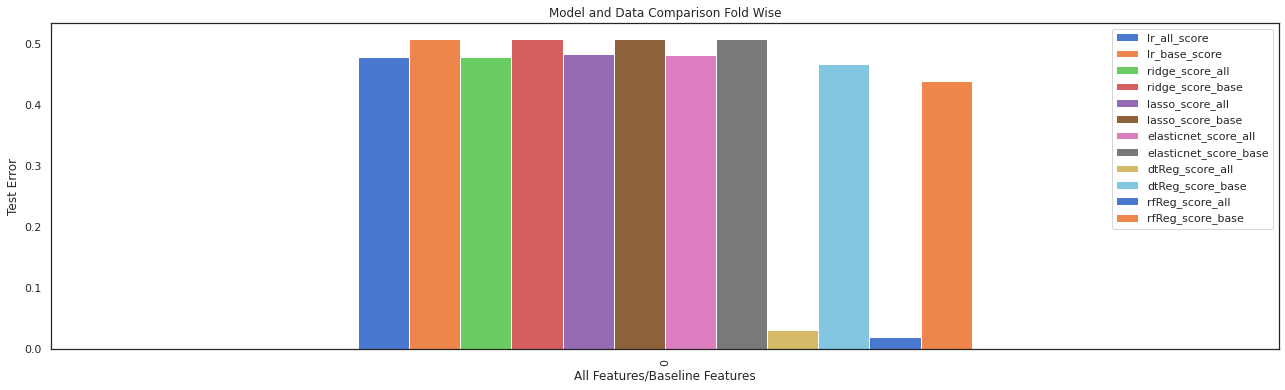

In [84]:
#linear regression, ridge, lasso, elasticnet, dtreg, rfreg
compare_score = pd.DataFrame({'lr_all_score':lr_all_score,
                              'lr_base_score':lr_base_score,
                              'ridge_score_all':ridge_score_all,
                              'ridge_score_base':ridge_score_base, 
                              'lasso_score_all':lasso_score_all, 
                              'lasso_score_base':lasso_score_base,
                              'elasticnet_score_all':elasticnet_score_all,
                              'elasticnet_score_base':elasticnet_score_base,
                              'dtReg_score_all':dtReg_score_all,
                              'dtReg_score_base':dtReg_score_base,
                              'rfReg_score_all':rfReg_score_all,
                              'rfReg_score_base':rfReg_score_base}, index=[0])

compare_score.plot(y = ['lr_all_score', 'lr_base_score','ridge_score_all',
                        'ridge_score_base','lasso_score_all','lasso_score_base',
                        'elasticnet_score_all','elasticnet_score_base', 'dtReg_score_all',
                        'dtReg_score_base', 'rfReg_score_all','rfReg_score_base'], 
                   kind = 'bar')

plt.title('Model and Data Comparison Fold Wise')
plt.xlabel('All Features/Baseline Features')
plt.ylabel('Test Error');

**From the bar plot above we can see that the Random Forest algorithm performed much better on the all_features_checkpoint data above all other algorithms of both the baseline_feats_checkpoint and the all_feats_checkpoint data.**

### Split the all_feats_checkpoint data

In [64]:
X_train, X_test, Y_train, Y_test = train_test_split(all_feats_checkpoint, y, test_size = 1/3, random_state=42)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(486191, 58) (486191,) (243096, 58) (243096,)


# Hyperparameter Tuning of Model using GridSearchCV

In [67]:
%%time
grid_param = {
    'n_estimators':[50, 100],
    'max_depth':[None],
    'min_samples_split':[10],
    'min_samples_leaf':[5],
    'max_features':['auto'],
    
    
}

# Initialize the RandomForestRegressor
rfReg = RandomForestRegressor(n_jobs=2)

# Setup GridSearchCV
grid_rfReg = GridSearchCV(estimator=rfReg,
                          param_grid=grid_param,
                          cv=5, verbose=2)

# Fit the GridSearch version of rfReg
trn_errors, val_errors, r_squared, fitted_model_grid, _ = cal_metrics(X_train = X_train, Y_train = Y_train, X_test = X_test, 
                                                                      Y_test = Y_test, model=grid_rfReg)

train_test_ratio = (round(val_errors/trn_errors, 1) * 10)
print(f"(train_error) --> {trn_errors} | (val_error) --> {val_errors} | (r2_score) --> {r_squared}\nThe Train/Test Error signifies that the Test Error is {train_test_ratio}% worse from the train error.\n")


print(fitted_model_grid.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time= 3.1min
[CV] END max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time= 3.2min
[CV] END max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time= 3.5min
[CV] END max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time= 3.5min
[CV] END max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time= 3.4min
[CV] END max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time= 6.3min
[CV] END max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time= 6.4min
[CV] END max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=10

In [65]:
# Train your model with the best parameters from GridSearch
model = RandomForestRegressor(max_depth = None, 
                              max_features = 'auto', 
                              min_samples_leaf = 5,
                              min_samples_split = 10,
                              n_estimators=50, 
                              n_jobs=2)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
model.fit(X_train_scaled, Y_train)

RandomForestRegressor(min_samples_leaf=5, min_samples_split=10, n_estimators=50,
                      n_jobs=2)

In [66]:
cols_todisplay = 60
importance_feat = model.feature_importances_
sorted_idx = np.argsort(importance_feat)[::-1]

print('These are the most importance Features\n')
for i in range(X_train.shape[1]):
    print(f"{i + 1,cols_todisplay} {all_feats_checkpoint.columns[sorted_idx[i]]} ----> {importance_feat[sorted_idx[i]]:.12f}\n")

These are the most importance Features

(1, 60) distance (km) ----> 0.340691677228

(2, 60) speed (km/h) ----> 0.332937203395

(3, 60) log_distance ----> 0.326292597267

(4, 60) dropoff_minute ----> 0.000019259676

(5, 60) pickup_minute ----> 0.000006869790

(6, 60) pickup_longitude_round3 ----> 0.000006732731

(7, 60) dropoff_longitude_round3 ----> 0.000006729304

(8, 60) dropoff_latitude_round3 ----> 0.000006007186

(9, 60) pickup_hour ----> 0.000005263314

(10, 60) dropoff_hour ----> 0.000005232173

(11, 60) pickup_latitude_round3 ----> 0.000005180696

(12, 60) pickup_week_of_year ----> 0.000003335098

(13, 60) dropoff_time_of_day_3 ----> 0.000002968703

(14, 60) dropoff_week_of_year ----> 0.000002669741

(15, 60) vendor_id_1 ----> 0.000002620310

(16, 60) dropoff_time_of_day_0 ----> 0.000000734213

(17, 60) dropoff_time_of_day_2 ----> 0.000000689810

(18, 60) pickup_time_of_day_0 ----> 0.000000592725

(19, 60) vendor_id_2 ----> 0.000000553613

(20, 60) passenger_count_1 ----> 0.000

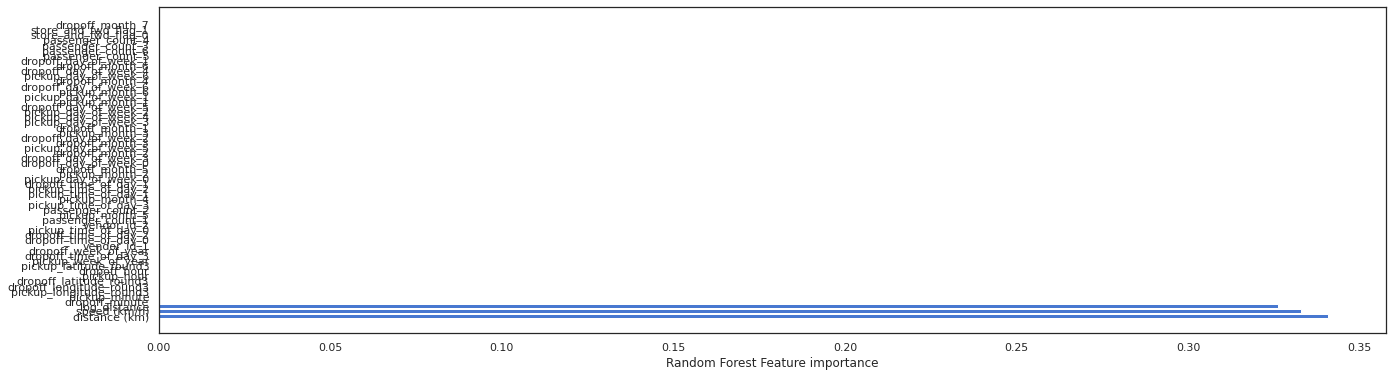

In [67]:
plt.barh(all_feats_checkpoint.columns[sorted_idx], importance_feat[sorted_idx][:60])
plt.xlabel('Random Forest Feature importance');

In [68]:
best_feats_to_train = all_feats_checkpoint[all_feats_checkpoint.columns[sorted_idx[:48]]]
best_feats_to_train

,distance (km),speed (km/h),log_distance,dropoff_minute,pickup_minute,pickup_longitude_round3,dropoff_longitude_round3,dropoff_latitude_round3,pickup_hour,dropoff_hour,pickup_latitude_round3,pickup_week_of_year,dropoff_time_of_day_3,dropoff_week_of_year,vendor_id_1,dropoff_time_of_day_0,dropoff_time_of_day_2,pickup_time_of_day_0,vendor_id_2,passenger_count_1,pickup_month_5,passenger_count_2,pickup_time_of_day_3,pickup_month_4,pickup_time_of_day_1,pickup_time_of_day_2,dropoff_time_of_day_1,pickup_day_of_week_0,pickup_month_2,dropoff_month_5,dropoff_day_of_week_0,dropoff_day_of_week_3,dropoff_month_2,pickup_day_of_week_5,dropoff_month_3,dropoff_day_of_week_2,pickup_month_3,dropoff_month_1,pickup_day_of_week_3,pickup_day_of_week_4,pickup_day_of_week_2,dropoff_day_of_week_5,pickup_month_1,pickup_day_of_week_1,pickup_month_6,dropoff_day_of_week_6,dropoff_month_4,pickup_day_of_week_6
0,1.199074,10.791668,0.181550,47,40,-73.954,-73.964,40.771,16,16,40.779,9,0,9,0,1,0,1,1,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4.129117,13.513473,1.418064,53,35,-73.988,-73.995,40.695,23,23,40.732,10,0,10,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
2,7.250763,15.964983,1.981107,26,59,-73.997,-73.948,40.775,17,18,40.721,7,0,7,0,1,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,2.361101,7.449573,0.859128,3,44,-73.962,-73.957,40.781,9,10,40.760,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0
4,4.328540,18.375877,1.465230,56,42,-74.017,-73.988,40.741,6,6,40.708,7,0,7,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729317,1.120224,13.624352,0.113529,34,29,-73.966,-73.953,40.789,13,13,40.790,20,1,20,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
729318,0.728706,8.328065,-0.316485,48,43,-73.997,-74.001,40.732,0,0,40.737,8,0,8,1,0,1,0,0,1,0,0,0,0,0,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
729319,2.298779,12.296587,0.832378,8,56,-73.998,-74.001,40.741,18,19,40.762,15,0,15,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
729320,0.846317,6.815975,-0.166861,58,50,-74.007,-74.014,40.714,9,9,40.708,24,0,24,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1


In [69]:
# Split the best features and fit the final model we will use to make predictions
X_train, X_test, Y_train, Y_test = train_test_split(best_feats_to_train, y, test_size = 1/3, random_state=42)

model_new = RandomForestRegressor(max_depth = None, 
                                  max_features = 'auto', 
                                  min_samples_leaf = 5,
                                  min_samples_split = 10,
                                  n_estimators=50,
                                  n_jobs=2)

new_trn_errors, new_val_errors, new_r_squared, final_model, fitted_scaler = cal_metrics(X_train = X_train, Y_train = Y_train, X_test = X_test, 
                                                                                        Y_test = Y_test, 
                                                                                        model = model_new)

train_test_ratio_ = (round(new_val_errors/new_trn_errors, 1) * 10)
print(f"(train_error) --> {new_trn_errors} | (val_error) --> {new_val_errors} | (r2_score) --> {new_r_squared}\nThe Train/Test Error signifies that the Test Error is {train_test_ratio_}% worse from the train error.\n")

(train_error) --> 0.013498794009875968 | (val_error) --> 0.020642325404315723 | (r2_score) --> 0.9993220941064082
The Train/Test Error signifies that the Test Error is 15.0% worse from the train error.



# Serialize both the Model and the fitted Scaler

In [70]:
with open('taxiDurationModel.pkl', 'wb') as f:
    pickle.dump(final_model, f)

In [84]:
with open('taxiDurationScaler.pkl', 'wb') as f:
    pickle.dump(fitted_scaler, f)

In [83]:
# True length of the best features
len(fitted_scaler.mean_)

48

In [91]:
# Check to see if there was any data leakage after storage
with open('taxiDurationScaler.pkl', 'rb') as file:
    l = pickle.load(file)
len(l.mean_)

48